In [2]:
!pip install tensorflow==2.18.0
!pip install onnx==1.14.0
!pip install tf2onnx==1.15.0
!pip install onnxruntime==1.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 25.2.10
    Uninstalling flatbuffers-25.2.10:
      Successfully uninstalled flatbuffers-25.2.10
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
tensorflow 2.18.0 requires flatbuffers>=24.3.25, but you have flatbuffers 2.0.7 which is incompatible.
tensorflow-metadata 1.16.1 requires prot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.2 MB/s eta 0:00:00


In [3]:
import os
import onnx
import tf2onnx
import onnxruntime as rt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model #imports

import matplotlib.pyplot as plt #imports

print("tensorflow version: ",{tf.__version__})

tensorflow version:  {'2.18.0'}


In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

#Dataset paths
path = 'drive/MyDrive/AgriLifeMicrohistologicalProject/LargeFeatureImages/SubImages 100 x 100'
#path = 'drive/MyDrive/AgriLifeMicrohistologicalProject/SubImages'
newpath = 'drive/MyDrive/AgriLifeMicrohistologicalProject/NewImages/Full'

Mounted at /content/drive


In [ ]:
def plotimg(images_arr, num_img):
  # Create a figure and axes.
  fig, axes = plt.subplots(1, num_img)
  # Flatten the axes array to easily iterate.
  axes = axes.flatten()
  # Iterate through images and corresponding axes.
  for img, ax in zip(images_arr * 255, axes):
    # Display the image on the current axis.
    ax.imshow(img)
    # Hide the axis ticks and labels.
    ax.axis('off')
  # Adjust subplot parameters for a tight layout.
  plt.tight_layout()
  # Display the plot.
  plt.show()

In [5]:
image_size = (100,100) #set image dimensions

# Create data generators for training, validation, and testing
train_datagen = ImageDataGenerator(validation_split=0.2)#dataset images

train = train_datagen.flow_from_directory( # Load training data
    path,
    target_size=image_size, #resize all uneven images
    batch_size=5500,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

X_train, y_train = train[0] # Extract training data and labels

valid = train_datagen.flow_from_directory( # Load training data
    path,
    target_size=image_size,
    batch_size=3000,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

X_val, y_val = valid[0] # Extract validation data and labels

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# Print data shapes
print(X_train.shape)
print(X_val.shape)

Found 3278 images belonging to 4 classes.
Found 817 images belonging to 4 classes.
(3278, 100, 100, 3)
(817, 100, 100, 3)


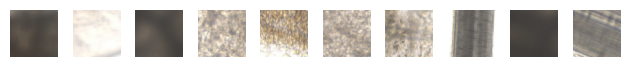

In [ ]:
plotimg(X_train[:10], 10) #plotimgs test

In [15]:
from keras import datasets, layers, models, callbacks
from keras.optimizers import Adam

# Create Adam optimizer with custom learning rate
optimizer = Adam(learning_rate=0.0001)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=10,         # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

# Load the InceptionV3 model (pretrained on ImageNet)
inception_backbone = keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,  # Exclude the classification layers
    input_shape=(100, 100, 3)  # Adjust input shape if needed
)
inception_backbone.trainable = True # Freeze the InceptionV3 layers to prevent them from being updated during training

# Create your custom Inception classification head (using your CNN architecture)
inputs = keras.Input(shape=(100, 100, 3))  # Adjust input shape if needed
x = inception_backbone(inputs, training=False)  # Pass inputs through InceptionV3

# Load the ResNet50 model (pretrained on ImageNet)
'''resnet_backbone = keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,  # Exclude the classification layers
    input_shape=(100, 100, 3)  # Adjust input shape if needed
)
resnet_backbone.trainable = True # Freeze the ResNet50 layers

# Create your custom ResNet50 classification head (using your CNN architecture)
inputs = keras.Input(shape=(100, 100, 3))  # Adjust input shape as needed
x = resnet_backbone(inputs, training=False)  # Pass inputs through ResNet50'''

x = layers.Conv2D(filters=32, kernel_size=(10, 10), activation='relu', padding = 'same')(x)
x = layers.MaxPooling2D((2, 2), padding = 'same')(x)

x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same')(x)
x = layers.MaxPooling2D((2, 2), padding  = 'same')(x)

x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
#x = layers.Dense(2128, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='sigmoid', name='output')(x)

# Create the complete model
cnn = keras.Model(inputs=inputs, outputs=outputs)

# Compile and train the model
cnn.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#cnn_history = cnn.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
cnn_history = cnn.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping]) #model trainer

print("\nValidation Accuracy: ")
cnn.evaluate(X_val, y_val) #validation accuracy

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 151s 525ms/step - accuracy: 0.3222 - loss: 0.6080 - val_accuracy: 0.4553 - val_loss: 0.4698
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.6677 - loss: 0.3598 - val_accuracy: 0.8898 - val_loss: 0.1544
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9161 - loss: 0.1244 - val_accuracy: 0.8286 - val_loss: 0.2618
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9344 - loss: 0.0923 - val_accuracy: 0.8703 - val_loss: 0.1947
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9503 - loss: 0.0632 - val_accuracy: 0.8752 - val_loss: 0.2197
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9674 - loss: 0.0461 - val_accuracy: 0.8715 - val_loss: 0.2169
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9736 - loss: 0.0429 - val_accuracy: 0.8678 - val_loss: 0.2410
Epoch 8/100
103/103 ━━━━━━━━━━━━━

[0.15442931652069092, 0.8898409008979797]

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 327ms/step
Predicted percentages labels for validation
[[0.42 0.13 0.37 0.  ]
 [1.   0.   0.   0.  ]
 [0.01 0.94 0.   0.01]
 [0.99 0.   0.   0.  ]]

Labels the model predicted for validation
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Actual labels for validation
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]

How the model performed for each class in validation data
[[80.9  5.3 12.7  1.6]
 [ 8.4 80.4  6.9  1.4]
 [11.   4.3 85.4  0. ]
 [ 0.9 10.1  0.3 93.5]]

GRAPHS


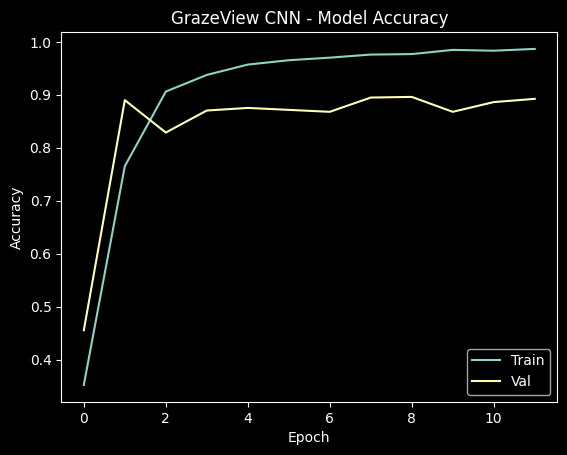

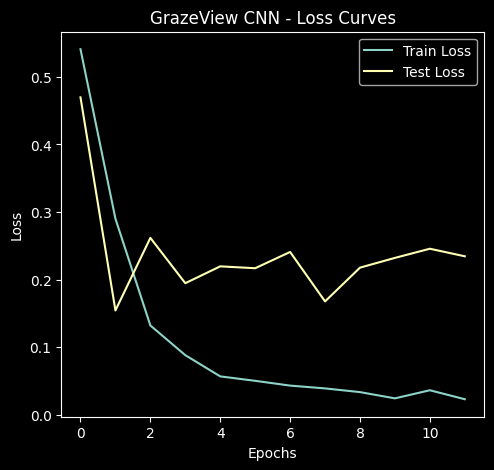

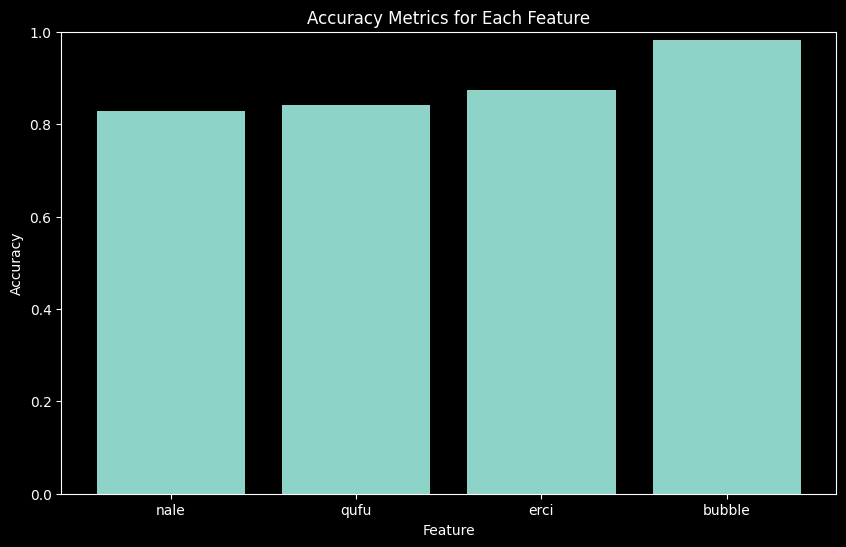

In [16]:
#[1. 0. 0. 0. 0.] - 0 - nale
#[0. 1. 0. 0. 0.] - 1 - qufu
#[0. 0. 1. 0. 0.] - 2 - erci
#[0. 0. 0. 1. 0.] - 3 - bubble
#[0. 0. 0. 0. 1.] - 4 - qufu stem

y_predicted_val = cnn.predict(X_val) #model prediction on validation
y_predicted_labels = tf.keras.utils.to_categorical(np.argmax(y_predicted_val, axis=1), num_classes=4) #one hot categorical predictions
y_predicted_rounded_percent = np.round(y_predicted_val, decimals=2) #rounded percents

#Print outs
print("Predicted percentages labels for validation")
print(y_predicted_rounded_percent[:4])
print("\nLabels the model predicted for validation")
print(y_predicted_labels[:4])
print("\nActual labels for validation")
print(y_val[:4])

class_percentages_list = []

# Iterate over each unique true class
for true_class in range(4):  # 4 classes
    # Find indices of samples belonging to the current true class
    indices = np.where(np.argmax(y_val, axis=1) == true_class)[0]

    # Get predicted probabilities for samples of the current true class
    class_probs = y_predicted_val[indices]

    # Calculate average percentages for each predicted class
    avg_percentages = np.mean(class_probs, axis=0) * 100

    #Rounds percents
    rounded_percentages = np.round(avg_percentages, decimals=1)

    #Appends to list
    class_percentages_list.append(rounded_percentages)

#Creates a numpy array of list
class_percentages = np.array(class_percentages_list)

print("\nHow the model performed for each class in validation data")
print(class_percentages)

print("\nGRAPHS")
plt.style.use('dark_background')

#Plots the overall model accuracy
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('GrazeView CNN - Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

#Plots the overall model loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Test Loss')
plt.title('GrazeView CNN - Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Assuming y_val and y_predicted_val are defined as in your provided code

num_classes = y_val.shape[1]  # Get the number of classes (4 in your case)
class_names = ['nale', 'qufu', 'erci', 'bubble']  # Define class names

# Calculate accuracy for each class separately
class_accuracies = []
for class_index in range(num_classes):
    # Find indices where true label matches the current class
    true_indices = np.where(y_val[:, class_index] == 1)[0]

    # Get predicted labels for the corresponding indices
    predicted_labels = y_predicted_val[true_indices, class_index]

    # Calculate accuracy for the current class
    accuracy = np.mean(predicted_labels.round() == y_val[true_indices, class_index])
    class_accuracies.append(accuracy)

# Plot the accuracies
plt.style.use('dark_background')  # Optional: Set dark background style
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
plt.bar(class_names, class_accuracies)
plt.title('Accuracy Metrics for Each Feature')
plt.xlabel('Feature')
plt.ylabel('Accuracy')
plt.ylim([0, 1])  # Set y-axis limits to 0-1 for accuracy
plt.show()

In [13]:
#Model predictions for the simulated new images data
test_datagen = ImageDataGenerator() # Normalize test data

test = test_datagen.flow_from_directory(
    newpath,
    target_size=image_size,
    batch_size=11000,
    class_mode='categorical'
)

X_test, y_test = test[0]# Extract test data and labels

X_test = X_test / 255.0

print(X_test.shape)

Found 10195 images belonging to 1 classes.
(10195, 100, 100, 3)


In [14]:
y_predicted = cnn.predict(X_test)
y_predicted_rounded = np.round(y_predicted, decimals=2) #rounded percents
print(y_predicted_rounded[:5])

#class_averages = np.mean(y_predicted, axis=0) #For new images, averages out all the predictions for each class
#print(f"Nale Percent: {class_averages[0] * 100:.2f}")
#print(f"Qufu Percent: {class_averages[1] * 100:.2f}")
#print(f"Erci Percent: {class_averages[2] * 100:.2f}")
#print(f"Bubble Percent: {class_averages[3] * 100:.2f}")

# Get the number of predictions (rows in y_predicted)
num_predictions = y_predicted.shape[0]

# Transpose y_predicted to get column sums
class_sums = np.sum(y_predicted, axis=0)

# Calculate average probabilities
average_probabilities = [col_sum / num_predictions for col_sum in class_sums]

print("\nPython Model Output")

print(f"\nNale Percent: {average_probabilities[0] * 100:.2f}")
print(f"Qufu Percent: {average_probabilities[1] * 100:.2f}")
print(f"Erci Percent: {average_probabilities[2] * 100:.2f}")
print(f"Bubble Percent: {average_probabilities[3] * 100:.2f}")

319/319 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step
[[0.99 0.01 0.01 0.  ]
 [0.82 0.28 0.01 0.  ]
 [1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]]

Python Model Output

Nale Percent: 35.59
Qufu Percent: 26.58
Erci Percent: 24.36
Bubble Percent: 12.65


In [27]:
# 1. Load the ONNX model
sess = rt.InferenceSession("GrazeView_accur91_fixedNale.onnx")

# 2. Get the input name for the model
input_name = sess.get_inputs()[0].name

# 3. Iterate through images in X_test and make predictions
all_predictions = []  # To store all predictions

for image in X_test:
    # Preprocess the image if necessary (e.g., reshape)
    image = image.reshape(1, *image.shape)  # Add batch dimension

    # Make prediction
    pred_onx = sess.run(None, {input_name: image.astype(np.float32)})[0]

    # Get class probabilities (assuming sigmoid output)
    probabilities = pred_onx  # If your model has a sigmoid output, probabilities are directly the output

    all_predictions.append(probabilities)  # Add to list of

num_predictions = len(all_predictions)

# Initialize class sums to 0
class_sums = [0] * len(all_predictions[0])  # Assuming all sublists have the same length

# Calculate class sums
for prediction in all_predictions:
    for i, prob in enumerate(prediction):
        class_sums[i] += prob

# Calculate average probabilities
average_probabilities = [col_sum / num_predictions for col_sum in class_sums]

print("ONNX Python Output")

print(f"\nNale Percent: {average_probabilities[0][0] * 100:.2f}")
print(f"Qufu Percent: {average_probabilities[0][1] * 100:.2f}")
print(f"Erci Percent: {average_probabilities[0][2] * 100:.2f}")
print(f"Bubble Percent: {average_probabilities[0][3] * 100:.2f}")

ONNX Python Output

Nale Percent: 35.82
Qufu Percent: 25.01
Erci Percent: 34.95
Bubble Percent: 7.42


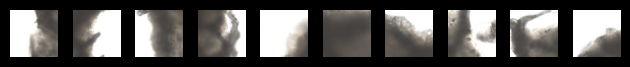

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
[[0.01 0.95 0.   0.02]
 [0.55 0.07 0.01 0.04]
 [0.13 0.81 0.03 0.  ]
 [0.05 0.94 0.01 0.  ]
 [0.11 0.09 0.   0.76]
 [0.01 0.99 0.   0.  ]
 [0.01 0.99 0.   0.  ]
 [0.78 0.33 0.02 0.  ]
 [0.37 0.91 0.   0.  ]
 [0.   0.85 0.   0.13]]


In [ ]:
indices = np.where(np.all(y_val == [0, 1, 0, 0], axis=1))[0] #change where the 1 is to change what feature you're looking at

# Get the images corresponding to the selected indices
selected_images = X_val[indices][40:50]

# Plot the selected images using the plotimg function
plotimg(selected_images, 10)

predicted_labels = cnn.predict(selected_images)
predicted_labels_rounded = np.round(predicted_labels, decimals=2)

# Print the predicted labels
print(predicted_labels_rounded)

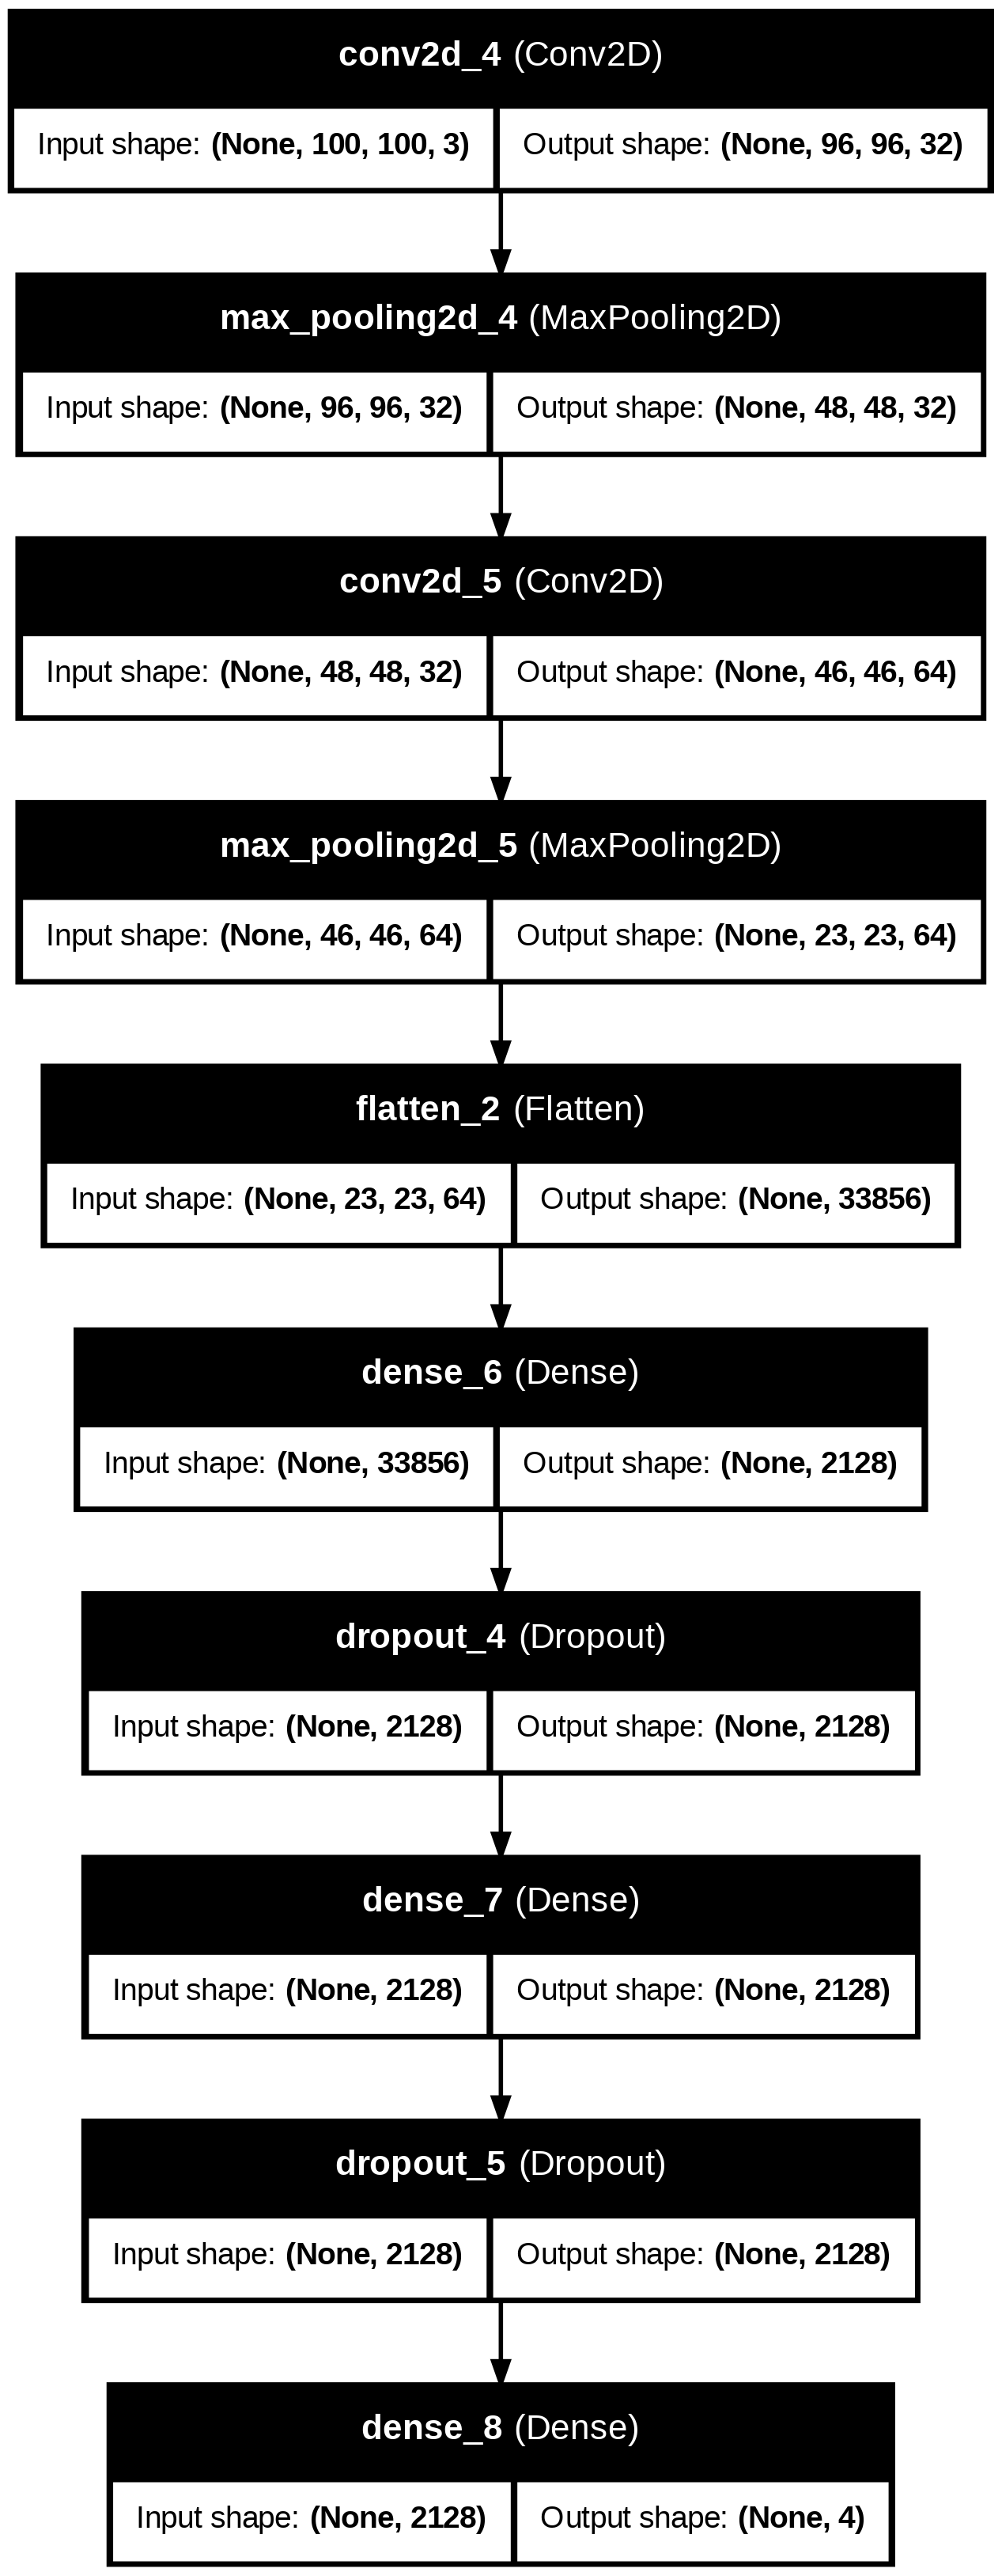

In [ ]:
#Creates a layout of model architecture
plot_model(cnn, to_file='model_dark.png', show_shapes=True,
           show_layer_names=True, rankdir='TB')

In [7]:
from keras import datasets, layers, models, callbacks
from keras.optimizers import Adam

# Create Adam optimizer with custom learning rate
optimizer = Adam(learning_rate=0.0001)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=10,         # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(10, 10), activation='relu', input_shape=(100, 100, 3), name = 'Godson_CNN'), #1st conv layers,
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(10, 10), activation='relu'), #2nd conv layer
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(2128, activation='relu'), #1st fully connected layers
    layers.Dropout(0.5),
    layers.Dense(2128, activation='relu'), #2nd dense layer
    layers.Dropout(0.5),
    layers.Dense(4, activation='sigmoid', name = 'output') #activation layer
])

#AlexNet inspired architecture
'''cnn = models.Sequential([
    layers.Conv2D(filters=96, kernel_size=(11, 11), activation='relu', input_shape=(100, 100, 3), strides = 4, name = 'Godson_CNN'), #1st conv layers,
    layers.MaxPooling2D((3, 3), strides=2),

    layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu'), #2nd conv layer
    layers.MaxPooling2D((3, 3), strides=2),

    layers.Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding = 'same'),
    layers.Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding = 'same'),
    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((3, 3), strides=2),

    layers.Flatten(),
    layers.Dense(4096, activation='relu'), #1st fully connected layers
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'), #2nd dense layer
    layers.Dropout(0.5),
    layers.Dense(1000, activation='relu'),
    layers.Dense(4, activation='sigmoid', name = 'output') #activation layer
])'''

cnn.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy']) #compiler

cnn_history = cnn.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping]) #model trainer
#cnn_history = cnn.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

print("\nValidation Accuracy: ")
cnn.evaluate(X_val, y_val) #validation accuracy

Epoch 1/100
103/103 [==============================] - 31s 286ms/step - loss: 0.5266 - accuracy: 0.3832 - val_loss: 0.5054 - val_accuracy: 0.4137
Epoch 2/100
103/103 [==============================] - 29s 281ms/step - loss: 0.4600 - accuracy: 0.4841 - val_loss: 0.4955 - val_accuracy: 0.3929
Epoch 3/100
103/103 [==============================] - 29s 281ms/step - loss: 0.4131 - accuracy: 0.5497 - val_loss: 0.3799 - val_accuracy: 0.6071
Epoch 4/100
103/103 [==============================] - 29s 278ms/step - loss: 0.3889 - accuracy: 0.6171 - val_loss: 0.3482 - val_accuracy: 0.6536
Epoch 5/100
103/103 [==============================] - 29s 279ms/step - loss: 0.2974 - accuracy: 0.7276 - val_loss: 0.2856 - val_accuracy: 0.7026
Epoch 6/100
103/103 [==============================] - 29s 279ms/step - loss: 0.2765 - accuracy: 0.7444 - val_loss: 0.2614 - val_accuracy: 0.7258
Epoch 7/100
103/103 [==============================] - 29s 278ms/step - loss: 0.2513 - accuracy: 0.7642 - val_loss: 0.3035 -

[0.22649718821048737, 0.806609570980072]

In [24]:
cnn.output_names = ['output']

onnx_model, _ = tf2onnx.convert.from_keras(cnn, opset=13)

onnx.save_model(onnx_model, "GrazeView_accur91_fixedNale.onnx")